In [1]:
from function_list import *

In [2]:
# Load data from the 2018-06-11 to the 2018-09-14

DIR_INPUT = 'simulated-data-transformed/' 

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

print("Load  files")
%time transactions_df = read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

output_feature = "TX_FRAUD"

input_features = ['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

Load  files
Wall time: 1.83 s
919767 transactions loaded, containing 8195 fraudulent transactions


In [3]:
# Number of folds for the prequential validation
n_folds = 4

# Set the starting day for the training period, and the deltas
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train = delta_delay = delta_test = delta_valid = delta_assessment = 7

start_date_training_for_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))
start_date_training_for_test = start_date_training+datetime.timedelta(days=(n_folds-1)*delta_test)

In [4]:
# Only keep columns that are needed as argument to the custom scoring function
# (in order to reduce the serialization time of transaction dataset)
transactions_df_scorer = transactions_df[['CUSTOMER_ID', 'TX_FRAUD','TX_TIME_DAYS']]

card_precision_top_100 = sklearn.metrics.make_scorer(card_precision_top_k_custom, 
                                                     needs_proba=True, 
                                                     top_k=100, 
                                                     transactions_df=transactions_df_scorer)

performance_metrics_list_grid = ['roc_auc', 'average_precision', 'card_precision@100']
performance_metrics_list = ['AUC ROC', 'Average precision', 'Card Precision@100']

scoring = {'roc_auc':'roc_auc',
           'average_precision': 'average_precision',
           'card_precision@100': card_precision_top_100,
           }

In [5]:
def model_selection_wrapper(transactions_df, 
                            classifier, 
                            input_features, output_feature,
                            parameters, 
                            scoring, 
                            start_date_training_for_valid,
                            start_date_training_for_test,
                            n_folds=4,
                            delta_train=7, 
                            delta_delay=7, 
                            delta_assessment=7,
                            performance_metrics_list_grid=['roc_auc'],
                            performance_metrics_list=['AUC ROC'],
                            n_jobs=-1):

    # Get performances on the validation set using prequential validation
    performances_df_validation=prequential_grid_search(transactions_df, classifier, 
                            input_features, output_feature,
                            parameters, scoring, 
                            start_date_training=start_date_training_for_valid,
                            n_folds=n_folds,
                            expe_type='Validation',
                            delta_train=delta_train, 
                            delta_delay=delta_delay, 
                            delta_assessment=delta_assessment,
                            performance_metrics_list_grid=performance_metrics_list_grid,
                            performance_metrics_list=performance_metrics_list,
                            n_jobs=n_jobs)
    
    # Get performances on the test set using prequential validation
    performances_df_test=prequential_grid_search(transactions_df, classifier, 
                            input_features, output_feature,
                            parameters, scoring, 
                            start_date_training=start_date_training_for_test,
                            n_folds=n_folds,
                            expe_type='Test',
                            delta_train=delta_train, 
                            delta_delay=delta_delay, 
                            delta_assessment=delta_assessment,
                            performance_metrics_list_grid=performance_metrics_list_grid,
                            performance_metrics_list=performance_metrics_list,
                            n_jobs=n_jobs)
    
    # Bind the two resulting DataFrames
    performances_df_validation.drop(columns=['Parameters','Execution time'], inplace=True)
    performances_df=pd.concat([performances_df_test,performances_df_validation],axis=1)

    # And return as a single DataFrame
    return performances_df

In [6]:
# Define classifier
classifier = sklearn.tree.DecisionTreeClassifier()

# Set of parameters for which to assess model performances
parameters = {'clf__max_depth':[2,3,4,5,6,7,8,9,10,20,50], 'clf__random_state':[0]}

start_time = time.time()

# Fit models and assess performances for all parameters
performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=1)

execution_time_dt = time.time()-start_time

# Select parameter of interest (max_depth)
parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['clf__max_depth'] for i in range(len(parameters_dict))]

# Rename to performances_df_dt for model performance comparison at the end of this notebook
performances_df_dt=performances_df

In [7]:
performances_df_dt

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.791909,0.017769,0.541761,0.031476,0.265000,0.019756,"{'clf__max_depth': 2, 'clf__random_state': 0}",0.509691,0.790786,0.012035,0.549767,0.022134,0.256429,0.014481,2
1,0.809012,0.009125,0.578885,0.014434,0.281429,0.015940,"{'clf__max_depth': 3, 'clf__random_state': 0}",0.454545,0.802717,0.017607,0.573414,0.027186,0.267143,0.016067,3
2,0.812555,0.010319,0.601088,0.020216,0.282500,0.015199,"{'clf__max_depth': 4, 'clf__random_state': 0}",0.489477,0.800690,0.017878,0.554134,0.038293,0.264286,0.014321,4
3,0.810138,0.008586,0.600306,0.016797,0.284286,0.004286,"{'clf__max_depth': 5, 'clf__random_state': 0}",0.511994,0.804218,0.016505,0.546094,0.042197,0.267857,0.013869,5
4,0.804437,0.007974,0.585132,0.005053,0.281429,0.007626,"{'clf__max_depth': 6, 'clf__random_state': 0}",0.542132,0.798603,0.024225,0.537006,0.037056,0.264643,0.008474,6
5,0.782710,0.012483,0.554860,0.011771,0.268929,0.009813,"{'clf__max_depth': 7, 'clf__random_state': 0}",0.651418,0.795636,0.023144,0.530609,0.040323,0.262500,0.006804,7
6,0.774783,0.014568,0.544933,0.003392,0.263571,0.007593,"{'clf__max_depth': 8, 'clf__random_state': 0}",0.667208,0.795142,0.023081,0.516246,0.033545,0.260714,0.009715,8
7,0.761763,0.012098,0.520208,0.012309,0.258571,0.009949,"{'clf__max_depth': 9, 'clf__random_state': 0}",0.726428,0.785849,0.026249,0.505189,0.040393,0.260357,0.009813,9
8,0.758138,0.011140,0.504909,0.013154,0.257500,0.010467,"{'clf__max_depth': 10, 'clf__random_state': 0}",0.753884,0.786784,0.031165,0.493543,0.048307,0.257143,0.009949,10
9,0.754024,0.009848,0.439422,0.034828,0.261071,0.014335,"{'clf__max_depth': 20, 'clf__random_state': 0}",1.236237,0.780408,0.022168,0.450980,0.031413,0.264286,0.007890,20


In [8]:
def get_summary_performances(performances_df, parameter_column_name="Parameters summary"):

    # Three performance metrics
    metrics = ['AUC ROC','Average precision','Card Precision@100']
    performances_results=pd.DataFrame(columns=metrics)
    
    # Reset indices in case a subset of a performane DataFrame is provided as input
    performances_df.reset_index(drop=True,inplace=True)

    # Lists of parameters/performances that will be retrieved for the best estimated parameters
    best_estimated_parameters = []
    validation_performance = []
    test_performance = []
    
    # For each performance metric, get the validation and test performance for the best estimated parameter
    for metric in metrics:
    
        # Find the index which provides the best validation performance
        index_best_validation_performance = performances_df.index[np.argmax(performances_df[metric+' Validation'].values)]
    
        # Retrieve the corresponding parameters
        best_estimated_parameters.append(performances_df[parameter_column_name].iloc[index_best_validation_performance])
        
        # Add validation performance to the validation_performance list (mean+/-std)
        validation_performance.append(
                str(round(performances_df[metric+' Validation'].iloc[index_best_validation_performance],3))+
                '+/-'+
                str(round(performances_df[metric+' Validation'+' Std'].iloc[index_best_validation_performance],2))
        )
        
        # Add test performance to the test_performance list (mean+/-std)
        test_performance.append(
                str(round(performances_df[metric+' Test'].iloc[index_best_validation_performance],3))+
                '+/-'+
                str(round(performances_df[metric+' Test'+' Std'].iloc[index_best_validation_performance],2))
        )
    
    # Add results to the performances_results DataFrame
    performances_results.loc["Best estimated parameters"]=best_estimated_parameters
    performances_results.loc["Validation performance"]=validation_performance
    performances_results.loc["Test performance"]=test_performance

    # Lists of parameters/performances that will be retrieved for the optimal parameters
    optimal_test_performance = []
    optimal_parameters = []

    # For each performance metric, get the performance for the optimal parameter
    for metric in ['AUC ROC Test','Average precision Test','Card Precision@100 Test']:
    
        # Find the index which provides the optimal performance
        index_optimal_test_performance = performances_df.index[np.argmax(performances_df[metric].values)]
    
        # Retrieve the corresponding parameters
        optimal_parameters.append(performances_df[parameter_column_name].iloc[index_optimal_test_performance])
    
        # Add test performance to the test_performance list (mean+/-std)
        optimal_test_performance.append(
                str(round(performances_df[metric].iloc[index_optimal_test_performance],3))+
                '+/-'+
                str(round(performances_df[metric+' Std'].iloc[index_optimal_test_performance],2))
        )

    # Add results to the performances_results DataFrame
    performances_results.loc["Optimal parameters"]=optimal_parameters
    performances_results.loc["Optimal test performance"]=optimal_test_performance
    
    return performances_results

In [9]:
summary_performances_dt=get_summary_performances(performances_df_dt, parameter_column_name="Parameters summary")
summary_performances_dt

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,50,3,5
Validation performance,0.823+/-0.01,0.573+/-0.03,0.268+/-0.01
Test performance,0.797+/-0.01,0.579+/-0.01,0.284+/-0.0
Optimal parameters,4,4,5
Optimal test performance,0.813+/-0.01,0.601+/-0.02,0.284+/-0.0


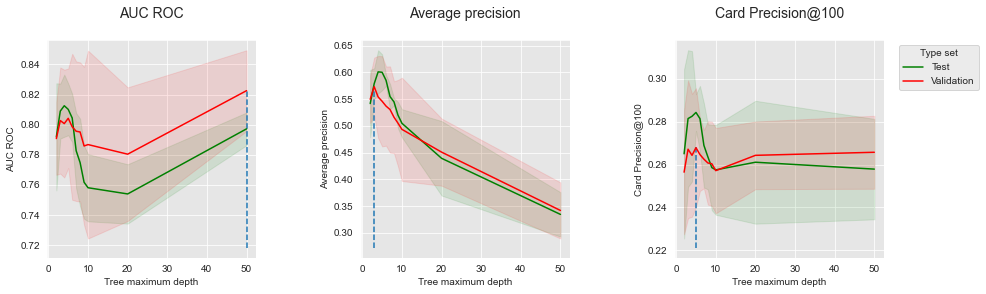

In [10]:
get_performances_plots(performances_df_dt, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       summary_performances=summary_performances_dt)

In [11]:
classifier = sklearn.linear_model.LogisticRegression()

parameters = {'clf__C':[0.1,1,10,100], 'clf__random_state':[0]}

start_time=time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=1)

execution_time_lr = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['clf__C'] for i in range(len(parameters_dict))]

# Rename to performances_df_lr for model performance comparison at the end of this notebook
performances_df_lr=performances_df

In [12]:
performances_df_lr

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.866972,0.014858,0.620231,0.015977,0.297143,0.008207,"{'clf__C': 0.1, 'clf__random_state': 0}",0.532920,0.865052,0.009591,0.608330,0.022740,0.278929,0.016300,0.1
1,0.867643,0.015404,0.623081,0.016204,0.297143,0.008806,"{'clf__C': 1, 'clf__random_state': 0}",0.516736,0.866861,0.008988,0.612264,0.023474,0.278214,0.016914,1.0
2,0.867678,0.015415,0.623224,0.016087,0.297500,0.008828,"{'clf__C': 10, 'clf__random_state': 0}",0.524076,0.867050,0.008918,0.612526,0.023715,0.277500,0.016763,10.0
3,0.867680,0.015419,0.623253,0.016074,0.297500,0.008828,"{'clf__C': 100, 'clf__random_state': 0}",0.488560,0.867071,0.008912,0.612537,0.023712,0.277500,0.016763,100.0


In [13]:
summary_performances_lr=get_summary_performances(performances_df_lr, parameter_column_name="Parameters summary")
summary_performances_lr

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,100.0,100.0,0.1
Validation performance,0.867+/-0.01,0.613+/-0.02,0.279+/-0.02
Test performance,0.868+/-0.02,0.623+/-0.02,0.297+/-0.01
Optimal parameters,100.0,100.0,10.0
Optimal test performance,0.868+/-0.02,0.623+/-0.02,0.298+/-0.01


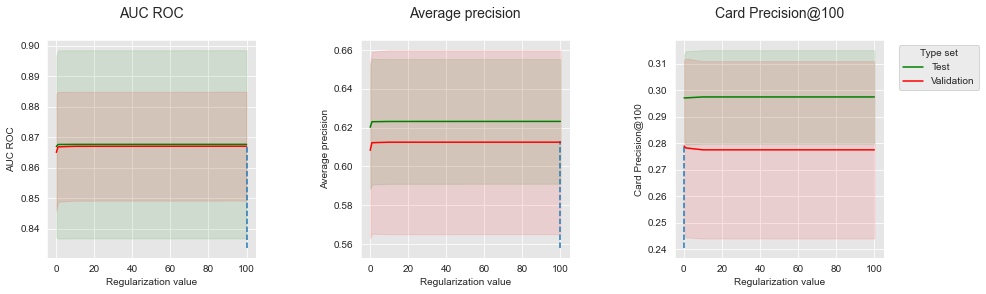

In [14]:
get_performances_plots(performances_df_lr, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Regularization value",
                       summary_performances=summary_performances_lr)

In [15]:
classifier = sklearn.ensemble.RandomForestClassifier()

# Note: n_jobs set to one for getting true execution times
parameters = {'clf__max_depth':[5,10,20,50], 'clf__n_estimators':[25,50,100],
              'clf__random_state':[0],'clf__n_jobs':[1]}

start_time=time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=1)

execution_time_rf = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[str(parameters_dict[i]['clf__n_estimators'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__max_depth'])
                                   for i in range(len(parameters_dict))]

# Rename to performances_df_rf for model performance comparison at the end of this notebook
performances_df_rf=performances_df

In [16]:
performances_df_rf

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.845287,0.003872,0.620712,0.022145,0.289286,0.010570,"{'clf__max_depth': 5, 'clf__n_estimators': 25,...",1.120362,0.834147,0.009100,0.610413,0.023740,0.274286,0.015551,25/5
1,0.850968,0.007508,0.620932,0.023824,0.290714,0.010996,"{'clf__max_depth': 5, 'clf__n_estimators': 50,...",3.076496,0.844140,0.007473,0.609801,0.027459,0.272857,0.015085,50/5
2,0.855230,0.007315,0.627034,0.021852,0.292500,0.010850,"{'clf__max_depth': 5, 'clf__n_estimators': 100...",4.541066,0.849065,0.011019,0.619450,0.026249,0.275000,0.016614,100/5
3,0.867271,0.006166,0.648583,0.012831,0.300714,0.010950,"{'clf__max_depth': 10, 'clf__n_estimators': 25...",2.112935,0.865000,0.002259,0.651858,0.020059,0.285357,0.012305,25/10
4,0.869225,0.007955,0.655050,0.014192,0.300000,0.012495,"{'clf__max_depth': 10, 'clf__n_estimators': 50...",3.987574,0.871323,0.004542,0.659386,0.021993,0.286786,0.015531,50/10
5,0.874949,0.011903,0.664613,0.014215,0.303214,0.013030,"{'clf__max_depth': 10, 'clf__n_estimators': 10...",7.714638,0.872388,0.005256,0.663481,0.024010,0.286429,0.017627,100/10
6,0.853581,0.014851,0.660131,0.013713,0.296429,0.012016,"{'clf__max_depth': 20, 'clf__n_estimators': 25...",3.437723,0.869824,0.005664,0.680407,0.016981,0.285357,0.014962,25/20
7,0.862653,0.016004,0.673352,0.011485,0.297143,0.013439,"{'clf__max_depth': 20, 'clf__n_estimators': 50...",6.319481,0.876311,0.006772,0.690434,0.019828,0.287143,0.016506,50/20
8,0.870378,0.016910,0.677675,0.011698,0.299286,0.013190,"{'clf__max_depth': 20, 'clf__n_estimators': 10...",11.429774,0.879728,0.006367,0.694063,0.020657,0.288571,0.016690,100/20
9,0.858527,0.008786,0.651899,0.009478,0.296429,0.010996,"{'clf__max_depth': 50, 'clf__n_estimators': 25...",2.991307,0.869956,0.003717,0.674013,0.021356,0.283929,0.016671,25/50


In [17]:
summary_performances_rf=get_summary_performances(performances_df_rf, parameter_column_name="Parameters summary")
summary_performances_rf

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,100/20,100/20,100/20
Validation performance,0.88+/-0.01,0.694+/-0.02,0.289+/-0.02
Test performance,0.87+/-0.02,0.678+/-0.01,0.299+/-0.01
Optimal parameters,100/10,100/20,100/10
Optimal test performance,0.875+/-0.01,0.678+/-0.01,0.303+/-0.01


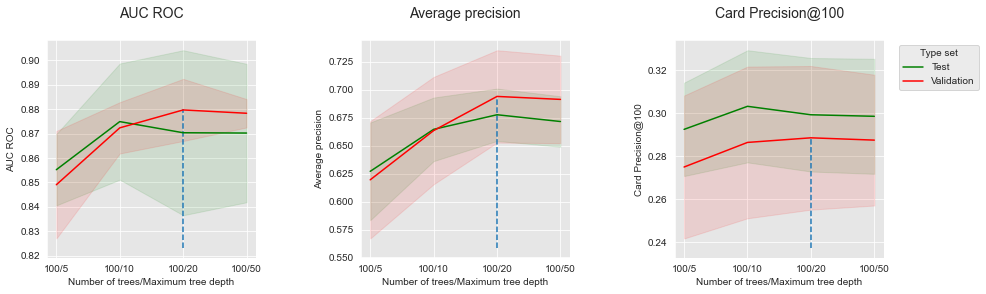

In [18]:
performances_df_rf_fixed_number_of_trees=performances_df_rf[performances_df_rf["Parameters summary"].str.startswith("100")]

summary_performances_fixed_number_of_trees=get_summary_performances(performances_df_rf_fixed_number_of_trees, parameter_column_name="Parameters summary")

get_performances_plots(performances_df_rf_fixed_number_of_trees, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Number of trees/Maximum tree depth",
                       summary_performances=summary_performances_fixed_number_of_trees)

In [19]:
# Get the performance plot for a single performance metric
def get_execution_times_plot(performances_df,
                             title="",
                             parameter_name="Tree maximum depth"):
    
    fig, ax = plt.subplots(1,1, figsize=(5,4))
    
    # Plot data on graph
    ax.plot(performances_df['Parameters summary'], performances_df["Execution time"], 
            color="black")
        
    # Set title, and x and y axes labels
    ax.set_title(title, fontsize=14)
    ax.set(xlabel = parameter_name, ylabel="Execution time (seconds)")

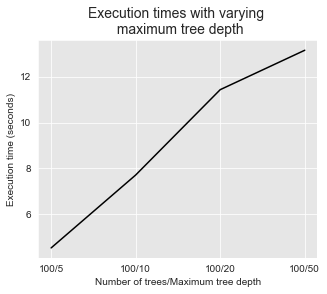

In [20]:
get_execution_times_plot(performances_df_rf_fixed_number_of_trees, 
                         title="Execution times with varying \n maximum tree depth",
                         parameter_name="Number of trees/Maximum tree depth")

In [21]:
print("Total execution time for the model selection procedure: "+str(round(execution_time_rf,2))+"s")

Total execution time for the model selection procedure: 534.43s


In [22]:
classifier = xgboost.XGBClassifier()

parameters = {'clf__max_depth':[3,6,9], 'clf__n_estimators':[25,50,100], 'clf__learning_rate':[0.1, 0.3],
              'clf__random_state':[0], 'clf__n_jobs':[1], 'clf__verbosity':[0]}

start_time=time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=1)

execution_time_boosting = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[str(parameters_dict[i]['clf__n_estimators'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__learning_rate'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__max_depth'])
                                   for i in range(len(parameters_dict))]

# Rename to performances_df_xgboost for model performance comparison at the end of this notebook
performances_df_xgboost=performances_df

In [23]:
performances_df_xgboost

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.833094,0.012257,0.635603,0.022225,0.296071,0.014859,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",2.211832,0.825157,0.009026,0.617990,0.025069,0.278214,0.015563,25/0.1/3
1,0.864766,0.006604,0.666130,0.012722,0.301429,0.013439,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",3.607732,0.863627,0.003203,0.651369,0.030279,0.280714,0.014932,50/0.1/3
2,0.870792,0.012352,0.694030,0.008394,0.303929,0.012305,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",7.331609,0.878438,0.009221,0.705235,0.019756,0.288214,0.015694,100/0.1/3
3,0.835862,0.012705,0.638601,0.025984,0.297500,0.014928,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",4.122547,0.843097,0.014918,0.640099,0.026283,0.278571,0.015551,25/0.1/6
4,0.871589,0.014202,0.686221,0.012026,0.301786,0.009603,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",6.856311,0.869654,0.002863,0.699780,0.016875,0.288214,0.016884,50/0.1/6
5,0.871278,0.011437,0.685991,0.008947,0.298571,0.010351,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",13.888500,0.881340,0.004587,0.706922,0.017461,0.286429,0.017217,100/0.1/6
6,0.852550,0.003171,0.656631,0.012632,0.302857,0.012164,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",4.973207,0.854345,0.008599,0.656910,0.023964,0.281429,0.012817,25/0.1/9
7,0.867596,0.016111,0.681919,0.011871,0.300000,0.009949,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",10.701934,0.875070,0.006199,0.700656,0.018366,0.285714,0.015779,50/0.1/9
8,0.862519,0.007472,0.674149,0.007838,0.293929,0.012428,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",20.920616,0.879667,0.003782,0.700592,0.017885,0.285000,0.017394,100/0.1/9
9,0.870988,0.014197,0.678544,0.012501,0.303214,0.012592,"{'clf__learning_rate': 0.3, 'clf__max_depth': ...",2.262959,0.877231,0.006120,0.698490,0.022835,0.288929,0.015131,25/0.3/3


In [24]:
summary_performances_xgboost=get_summary_performances(performances_df_xgboost, parameter_column_name="Parameters summary")
summary_performances_xgboost

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,100/0.3/3,50/0.3/3,25/0.3/3
Validation performance,0.887+/-0.01,0.708+/-0.02,0.289+/-0.02
Test performance,0.869+/-0.01,0.687+/-0.01,0.303+/-0.01
Optimal parameters,50/0.3/3,100/0.1/3,100/0.1/3
Optimal test performance,0.872+/-0.01,0.694+/-0.01,0.304+/-0.01


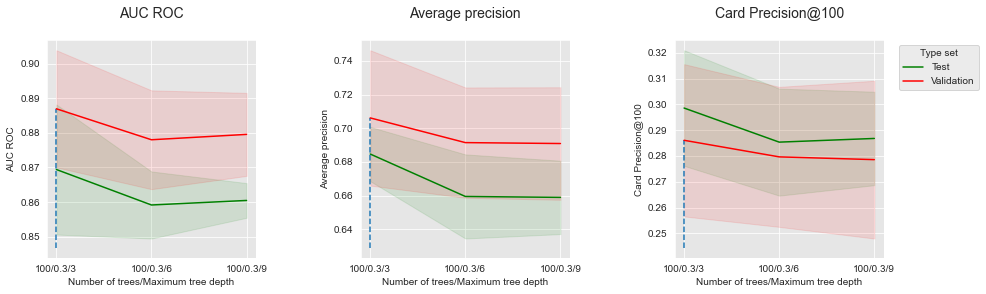

In [25]:
performances_df_xgboost_fixed_number_of_trees=performances_df_xgboost[performances_df_xgboost["Parameters summary"].str.startswith("100/0.3")]

summary_performances_fixed_number_of_trees=get_summary_performances(performances_df_xgboost_fixed_number_of_trees, parameter_column_name="Parameters summary")

get_performances_plots(performances_df_xgboost_fixed_number_of_trees, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Number of trees/Maximum tree depth",
                       summary_performances=summary_performances_fixed_number_of_trees)

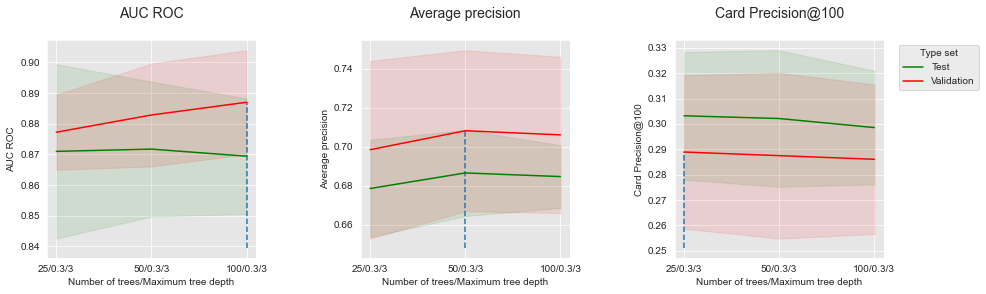

In [26]:
performances_df_xgboost_fixed_max_tree_depth=performances_df_xgboost[performances_df_xgboost["Parameters summary"].str.endswith("0.3/3")]

summary_performances_fixed_max_tree_depth=get_summary_performances(performances_df_xgboost_fixed_max_tree_depth, parameter_column_name="Parameters summary")

get_performances_plots(performances_df_xgboost_fixed_max_tree_depth, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Number of trees/Maximum tree depth",
                       summary_performances=summary_performances_fixed_max_tree_depth)

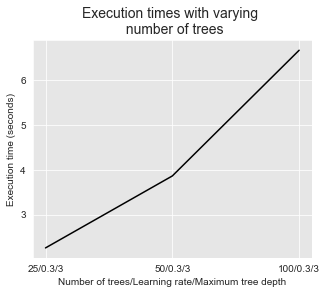

In [27]:
get_execution_times_plot(performances_df_xgboost_fixed_max_tree_depth, 
                         title="Execution times with varying \n number of trees",
                         parameter_name="Number of trees/Learning rate/Maximum tree depth")

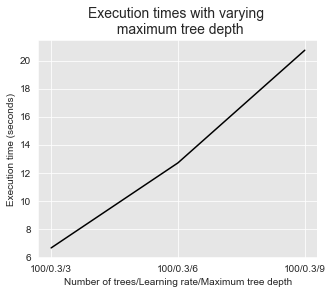

In [28]:
get_execution_times_plot(performances_df_xgboost_fixed_number_of_trees, 
                         title="Execution times with varying \n maximum tree depth",
                         parameter_name="Number of trees/Learning rate/Maximum tree depth")

In [29]:
print("Total execution time for the model selection procedure: "+str(round(execution_time_boosting,2))+"s")

Total execution time for the model selection procedure: 1148.14s


In [30]:
performances_df_dictionary={
    "Decision Tree": performances_df_dt,
    "Logistic Regression": performances_df_lr,
    "Random Forest": performances_df_rf,
    "XGBoost": performances_df_xgboost
}

In [31]:
def model_selection_performances(performances_df_dictionary,
                                 performance_metric='AUC ROC',
                                 model_classes=['Decision Tree', 
                                                'Logistic Regression', 
                                                'Random Forest', 
                                                'XGBoost'],
                                 default_parameters_dictionary={
                                                "Decision Tree": 50,
                                                "Logistic Regression": 1,
                                                "Random Forest": "100/50",
                                                "XGBoost": "100/0.3/6"
                                            }):
    
    mean_performances_dictionary={
        "Default parameters": [],
        "Best validation parameters": [],
        "Optimal parameters": []
    }
    
    std_performances_dictionary={
        "Default parameters": [],
        "Best validation parameters": [],
        "Optimal parameters": []
    }
    
    # For each model class
    for model_class in model_classes:
        
        performances_df=performances_df_dictionary[model_class]
        
        # Get the performances for the default paramaters
        default_performances=performances_df[performances_df['Parameters summary']==default_parameters_dictionary[model_class]]
        default_performances=default_performances.round(decimals=3)
        
        mean_performances_dictionary["Default parameters"].append(default_performances[performance_metric+" Test"].values[0])
        std_performances_dictionary["Default parameters"].append(default_performances[performance_metric+" Test Std"].values[0])
        
        # Get the performances for the best estimated parameters
        performances_summary=get_summary_performances(performances_df, parameter_column_name="Parameters summary")
        mean_std_performances=performances_summary.loc[["Test performance"]][performance_metric].values[0]
        mean_std_performances=mean_std_performances.split("+/-")
        mean_performances_dictionary["Best validation parameters"].append(float(mean_std_performances[0]))
        std_performances_dictionary["Best validation parameters"].append(float(mean_std_performances[1]))
        
        # Get the performances for the boptimal parameters
        mean_std_performances=performances_summary.loc[["Optimal test performance"]][performance_metric].values[0]
        mean_std_performances=mean_std_performances.split("+/-")
        mean_performances_dictionary["Optimal parameters"].append(float(mean_std_performances[0]))
        std_performances_dictionary["Optimal parameters"].append(float(mean_std_performances[1]))
        
    # Return the mean performances and their standard deviations    
    return (mean_performances_dictionary,std_performances_dictionary)

In [32]:
model_selection_performances(performances_df_dictionary,
                             performance_metric='AUC ROC')

({'Default parameters': [0.797, 0.868, 0.87, 0.859],
  'Best validation parameters': [0.797, 0.868, 0.87, 0.869],
  'Optimal parameters': [0.813, 0.868, 0.875, 0.872]},
 {'Default parameters': [0.005, 0.015, 0.014, 0.005],
  'Best validation parameters': [0.01, 0.02, 0.02, 0.01],
  'Optimal parameters': [0.01, 0.02, 0.01, 0.01]})

In [33]:
# Get the performance plot for a single performance metric
def get_model_selection_performance_plot(performances_df_dictionary, 
                                         ax, 
                                         performance_metric,
                                         ylim=[0,1],
                                         model_classes=['Decision Tree', 
                                                        'Logistic Regression', 
                                                        'Random Forest', 
                                                        'XGBoost']):
    
    
    (mean_performances_dictionary,std_performances_dictionary) = \
        model_selection_performances(performances_df_dictionary=performances_df_dictionary,
                                     performance_metric=performance_metric)
    
    
    # width of the bars
    barWidth = 0.3
    # The x position of bars
    r1 = np.arange(len(model_classes))
    r2 = r1+barWidth
    r3 = r1+2*barWidth
    
    # Create Default parameters bars (Orange)
    ax.bar(r1, mean_performances_dictionary['Default parameters'], 
           width = barWidth, color = '#CA8035', edgecolor = 'black', 
           yerr=std_performances_dictionary['Default parameters'], capsize=7, label='Default parameters')
 
    # Create Best validation parameters bars (Red)
    ax.bar(r2, mean_performances_dictionary['Best validation parameters'], 
           width = barWidth, color = '#008000', edgecolor = 'black', 
           yerr=std_performances_dictionary['Best validation parameters'], capsize=7, label='Best validation parameters')

    # Create Optimal parameters bars (Green)
    ax.bar(r3, mean_performances_dictionary['Optimal parameters'], 
           width = barWidth, color = '#2F4D7E', edgecolor = 'black', 
           yerr=std_performances_dictionary['Optimal parameters'], capsize=7, label='Optimal parameters')
 

    # Set title, and x and y axes labels
    ax.set_ylim(ylim[0],ylim[1])
    ax.set_xticks(r2+barWidth/2)
    ax.set_xticklabels(model_classes, rotation = 45, ha="right", fontsize=12)
    ax.set_title(performance_metric+'\n', fontsize=18)
    ax.set_xlabel("Model class", fontsize=16)
    ax.set_ylabel(performance_metric, fontsize=15)

In [34]:
def get_model_selection_performances_plots(performances_df_dictionary, 
                                           performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'],
                                           ylim_list=[[0.6,0.9],[0.2,0.8],[0.2,0.35]],
                                           model_classes=['Decision Tree', 
                                                          'Logistic Regression', 
                                                          'Random Forest', 
                                                          'XGBoost']):
    
    # Create as many graphs as there are performance metrics to display
    n_performance_metrics = len(performance_metrics_list)
    fig, ax = plt.subplots(1, n_performance_metrics, figsize=(5*n_performance_metrics,4))
    
    parameter_types=['Default parameters','Best validation parameters','Optimal parameters']
    
    # Plot performance metric for each metric in performance_metrics_list
    for i in range(n_performance_metrics):
    
        get_model_selection_performance_plot(performances_df_dictionary, 
                                             ax[i], 
                                             performance_metrics_list[i],
                                             ylim=ylim_list[i],
                                             model_classes=model_classes
                                            )
    
    ax[n_performance_metrics-1].legend(loc='upper left', 
                                       labels=parameter_types, 
                                       bbox_to_anchor=(1.05, 1),
                                       title="Parameter type",
                                       prop={'size': 12},
                                       title_fontsize=12)

    plt.subplots_adjust(wspace=0.5, 
                        hspace=0.8)

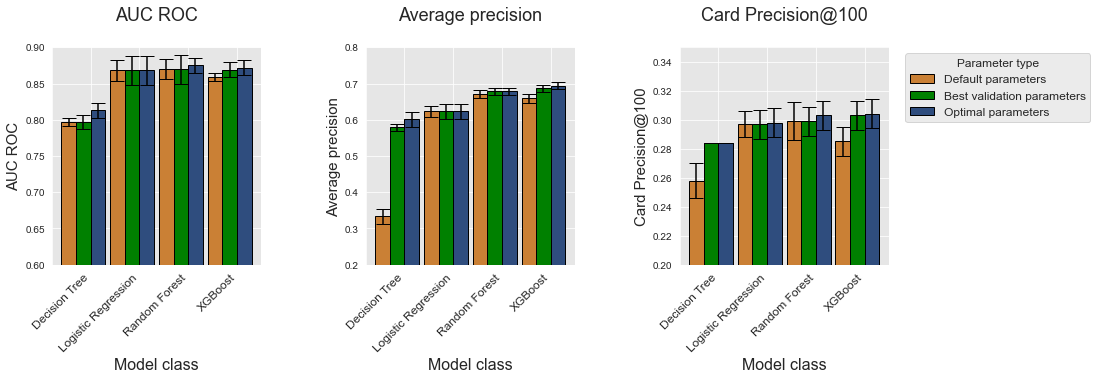

In [35]:
get_model_selection_performances_plots(performances_df_dictionary, 
                                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'])
    

In [36]:
execution_times=[execution_time_dt,execution_time_lr,
                 execution_time_rf,execution_time_boosting]

In [37]:
%%capture

fig_model_selection_execution_times_for_each_model_class, ax = plt.subplots(1, 1, figsize=(5,4))

model_classes=['Decision Tree','Logistic Regression','Random Forest','XGBoost']
    
# width of the bars
barWidth = 0.3
# The x position of bars
r1 = np.arange(len(model_classes))
    
# Create execution times bars
ax.bar(r1, execution_times[0:4], 
        width = barWidth, color = 'black', edgecolor = 'black', 
        capsize=7)

ax.set_xticks(r1+barWidth/2)
ax.set_xticklabels(model_classes, rotation = 45, ha="right", fontsize=12)
ax.set_title('Model selection execution times \n for different model classes', fontsize=18)
ax.set_xlabel("Model class", fontsize=16)
ax.set_ylabel("Execution times (s)", fontsize=15)

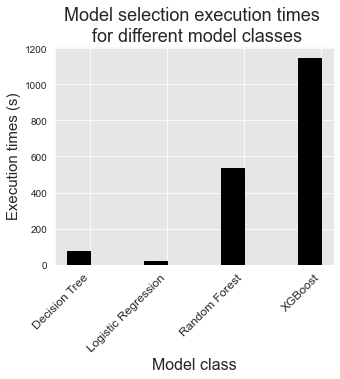

In [38]:
fig_model_selection_execution_times_for_each_model_class